# Prerequisite
* Load required packages and load images (already uploaded on  Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the demo on Blackboard by April 05, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following numpy and tensorflow/pytorch functions for any operations**

In [1]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 28.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
from scipy import ndimage as nd
from scipy import interpolate as inter
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import scipy.linalg as scla ## For Eigenvalue and Eigenvectors

In [3]:
def RMSD(img1,img2):
  out1 = np.sqrt(np.power(img1-img2, 2).sum()/np.prod(img1.shape))
  return out1

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def make_noisy(noise_typ,image):
   if noise_typ == "gauss": #Gaussian Noise
      row,col = image.shape
      mean = 0
      #var = 0.05
      #sigma = var**0.5
      intensity_range = image.max()-image.min()

      ###### IMPORTANT ##########################################
      sigma = 0.1*intensity_range    ###### 10% of Gaussian NOISE
      ###########################################################

      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p": # Salt and Pepper Noise
      row,col  = image.shape
      s_vs_p = 0.5
      amount = 0.7 # 0.004
      noisy = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = tuple([np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape])
      noisy[coords] = 1 # adding random white pixels

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape])
      noisy[coords] = 0 # adding random black pixels
      return noisy

#Q1) PCA for Image Denoising
<p align="justify"> <b>Download the 'barbara.tif'</b> from BlackBoard. Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes. <b>Corrupt the image</b> with independent and identically-distributed additive zero-mean Gaussian noise with standard deviation $\sigma$ set to 10% of the intensity range. </p>
<p>

In [4]:
img_path =  '/content/barbara.tif'
img1 = imageio.imread(img_path)
img1_a = rgb2gray(img1.astype(np.float32))
#####################  Not Part of Solution ############################
print('Original Data_type is {}'.format(img1.dtype))
print('Data_type is', img1_a.dtype)
print('Image Size is {}'.format(img1_a.shape))
print('Image min and max are ({}, {})'.format(img1_a.min(),img1_a.max()))
#########################################################################

Original Data_type is uint8
Data_type is float64
Image Size is (512, 512)
Image min and max are (6.9993, 240.97589999999997)


##(a) [**0 Marks**] Show the Original Image

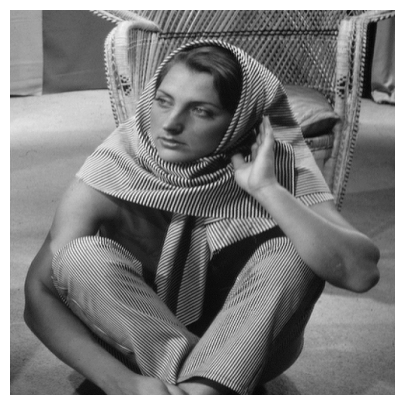

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(img1_a, cmap='gray')
plt.axis('off')
plt.show()

##(b)[**0 Points**] Show the Corrupted image

<p>Consider Patch $P_{ij}$ of size $7 \times 7$ around pixel location $(i,j)$ in <b>Corrupted image</b>.
Randomly collect $K=290$ $(7 \times 7)$ patches from within a $31\times 31$ neighborhood centered at $(i,j)$.</p>
[Note: make sure $P_{ij}$ should be part of $290$ patches]
<p>
Let ${\bar P_{ij}}$ be $(49×1)$ column vector of patch $P_{ij}$.
</p>
<p>
Let $X_{ij}$ be matrix of size $(49×290)$, where each column represents $7\times 7$ patch from $290$ patches.
Let $C_{ij} = X_{ij}X_{ij}^T$ is $(49×49)$ matrix.
</p>
<p>$w_{ij},v_{ij} = numpy.linalg.eig(C_{ij})$</p>
<p>
Where $w_{ij}$ is $(49×1)$ matrix with eigenvalues of $C_{ij}$ and $v_{ij}$ is $(49×49)$ matrix with corresponding eigenvectors of $C_{ij}$ in columns. Make sure all eigenvectors are unit norm.
</p>
<p>
Let $\alpha_{ij}^k = v_{ij}^TX_{ij}[:,k]$, for $k = \{1,2,...,K\}$, be matrix of size $(49×1)$.
</p>
<p>
Let ${\bar \alpha}_{ij}^2[l] = max(0,\frac{1}{K}\sum_{k=1}^K((\alpha_{ij}^k[l])^2-\sigma^2))$, where $l=\{1,2,...,49\}$
</p>
<p>
Let $\alpha_{ij} = v_{ij}^T{\bar P_{ij}}$, be matrix of size $(49×1)$.
</p>
<p>
Now, $\beta_{ij}[l] = \frac{1}{1+\frac{\sigma^2}{{\bar \alpha}_{ij}^2[l]}}\alpha_{ij}[l]$, where $l=\{1,2,...,49\}$ and $\beta_{ij}$ is a matrix of size $(49×1)$.
</p>
<p>
Let ${\bar Q_{ij}}= v_{ij}\beta_{ij}$ be matrix of size $(49×1)$. Now let $Q_{ij}$ be $(7×7)$ denoised patch from ${\bar Q_{ij}}$.
</p>
<p>
Now replace patch $P_{ij}$ with patch $Q_{ij}$ to denoise image.  

In [6]:
wsize = 31
psize = 9
ITER = 5
intensity_range = img1_a.max()-img1_a.min()
sigma = 0.1*intensity_range    ###### 10% of Gaussian NOISE
print(sigma)

23.39766


In [18]:
noisy_img = make_noisy("gauss", img1_a)
i, j = 50, 50
K = 290
neighbour_size = 31
patch_size = 7
random_R = (neighbour_size - patch_size) // 2
noisy_padded = np.pad(noisy_img, ((neighbour_size, neighbour_size), (neighbour_size, neighbour_size)), mode='symmetric')

for i_val in range(neighbour_size, noisy_padded.shape[0] - neighbour_size, patch_size):
    print(i_val)
    for j_val in range(neighbour_size, noisy_padded.shape[1] - neighbour_size, patch_size):
        pij = noisy_padded[i_val - patch_size // 2: i_val + patch_size // 2 + 1, j_val - patch_size // 2: j_val + patch_size // 2 + 1]
        p_bar = pij.reshape(-1)
        xij_t = np.empty((K, patch_size * patch_size), dtype=np.float32)

        for x in range(K):
            i_offset = np.random.randint(i_val - random_R, i_val + random_R + 1)
            j_offset = np.random.randint(j_val - random_R, j_val + random_R + 1)

            p_sample = noisy_padded[i_offset: i_offset + patch_size, j_offset: j_offset + patch_size]
            p_sample_bar = p_sample.reshape(-1)
            xij_t[x] = p_sample_bar

        xij = np.transpose(xij_t)
        cij = np.matmul(xij, xij_t)
        wij, vij = np.linalg.eig(cij)
        vij_t = np.transpose(vij)

        aij = np.matmul(vij_t, p_bar)
        aij_neg2 = np.zeros((patch_size * patch_size), dtype=np.float32)
        bij = np.empty((patch_size * patch_size), dtype=np.float32)

        sigma = 0.1  # Assuming a value for sigma, you can adjust this as needed

        for k in range(1, K):
            aij_neg2 += np.square(np.matmul(vij_t, xij[:, k])) - np.square(sigma)

        aij_neg2 = np.maximum(0, aij_neg2 / 290)
        bij = aij / (1 + (np.square(sigma) / aij_neg2))

        qij_bar = np.matmul(vij, bij)
        qij = qij_bar.reshape(patch_size, patch_size)
        noisy_padded[i_val - patch_size // 2: i_val + patch_size // 2 + 1, j_val - patch_size // 2: j_val + patch_size // 2 + 1] = qij

31
38
45
52
59
66
73
80
87
94
101
108
115
122
129
136
143
150
157
164
171
178
185
192
199
206
213
220
227
234
241
248
255
262
269
276
283
290
297
304
311
318
325
332
339
346
353
360
367
374
381
388
395
402
409
416
423
430
437
444
451
458
465
472
479
486
493
500
507
514
521
528
535
542


##(c)[**4 Points**] Plot image of $max(w_{ij})$, which will be same size as original image

<ipython-input-19-9bc468aaf56f>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  max_eigenvalues[i_val - patch_size // 2: i_val + patch_size // 2 + 1, j_val - patch_size // 2: j_val + patch_size // 2 + 1] = max_eigenvalue


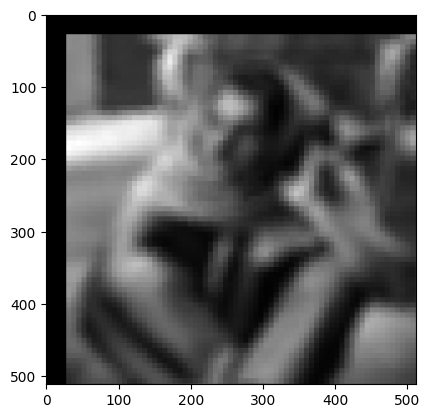

In [19]:
max_eigenvalues = np.zeros_like(noisy_img)

# Iterate over the patches in the image
for i_val in range(neighbour_size, noisy_padded.shape[0] - neighbour_size, patch_size):
    for j_val in range(neighbour_size, noisy_padded.shape[1] - neighbour_size, patch_size):
        patch = noisy_padded[i_val - patch_size // 2: i_val + patch_size // 2 + 1, j_val - patch_size // 2: j_val + patch_size // 2 + 1]
        patch_vector = patch.reshape(-1)
        samples = np.empty((K, patch_size * patch_size), dtype=np.float32)

        # Generate random samples around the current patch
        for k in range(K):
            i_offset = np.random.randint(i_val - random_R, i_val + random_R + 1)
            j_offset = np.random.randint(j_val - random_R, j_val + random_R + 1)

            sample_patch = noisy_padded[i_offset: i_offset + patch_size, j_offset: j_offset + patch_size]
            sample_vector = sample_patch.reshape(-1)
            samples[k] = sample_vector

        samples_transpose = np.transpose(samples)
        covariance_matrix = np.matmul(samples, samples_transpose)
        eigenvalues, _ = np.linalg.eig(covariance_matrix)

        # Compute the max eigenvalue for the current patch
        max_eigenvalue = np.max(eigenvalues)

        # Store the max eigenvalue in the corresponding location in the max_eigenvalues array
        max_eigenvalues[i_val - patch_size // 2: i_val + patch_size // 2 + 1, j_val - patch_size // 2: j_val + patch_size // 2 + 1] = max_eigenvalue

# Plot the max eigenvalues
plt.imshow(max_eigenvalues, cmap='gray')
plt.show()

##(d)[**4 Points**]Show the Denoised Image

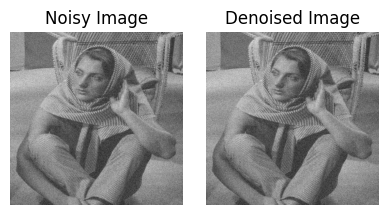

In [20]:
# Remove the padding to get the denoised image
denoised_img = noisy_padded[neighbour_size:-neighbour_size, neighbour_size:-neighbour_size]

# Display the noisy image
plt.figure(figsize=(8, 6))
plt.subplot(3, 4, 1)
plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

# Display the denoised image
plt.subplot(3, 4, 2)
plt.imshow(denoised_img, cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.tight_layout()
plt.show()

##(e)[**2 Points**] Print RMSE value between original image and Denoised image

In [21]:
rmsd_value = RMSD(img1_a, denoised_img)
print(f"RMSD between original and denoised images: {rmsd_value:.4f}")

RMSD between original and denoised images: 23.3818
